In [1]:
import json

# 方法名称列表
methods = ["kgw", "our1", "our0"]

# accuracy 和 perplexity JSON 键映射字典
acc_keys = {
    "kgw": "eval_kgw",
    "our1": "eval_our1",
    "our0": "eval_our0"
}

ppl_keys = {
    "kgw": "avg_kgw",
    "our1": "avg_ourwm_1",
    "our0": "avg_ourwm"
}

# 假设路径列表如下（你实际使用时填入真实路径）
accuracy_json_paths = ["/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d1.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d1.25.json", "/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d1.5.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d2.5.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d3.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/eval_results_d3.5.json"]

perplexity_json_paths = ["/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d1.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d1.25.json", "/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d1.5.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d2.5.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d3.json","/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/ppl_d3.5.json"]

# 初始化方法结果存储结构
method_data = {method: [] for method in methods}

# 遍历所有路径对
for acc_path, ppl_path in zip(accuracy_json_paths, perplexity_json_paths):
    with open(acc_path, 'r') as f_acc, open(ppl_path, 'r') as f_ppl:
        acc_json = json.load(f_acc)
        ppl_json = json.load(f_ppl)

    for method in methods:
        acc_key = acc_keys[method]
        ppl_key = ppl_keys[method]

        try:
            acc = acc_json[acc_key]["tpr@1"]
            ppl = ppl_json[ppl_key]
            method_data[method].append((acc, ppl))
        except KeyError as e:
            print(f"[警告] 方法 {method} 缺少键：{e}，文件对：{acc_path}, {ppl_path}")
            continue


In [2]:
method_data

{'kgw': [(0.916, 11.634486425161361),
  (0.976, 12.220626168727875),
  (0.996, 12.875684875249863),
  (0.994, 17.1924532995224),
  (0.998, 20.523367400169374),
  (1.0, 24.338962842464447)],
 'our1': [(0.89, 11.177436762094498),
  (0.984, 11.468927674293518),
  (0.996, 11.765362533569336),
  (1.0, 13.21041401720047),
  (1.0, 13.620498745918274),
  (1.0, 14.367797318935395)],
 'our0': [(0.93, 11.47217517375946),
  (0.98, 11.631646991252898),
  (0.996, 11.88316524028778),
  (1.0, 13.076075713157653),
  (1.0, 13.62383824300766),
  (1.0, 13.493131339073182)]}

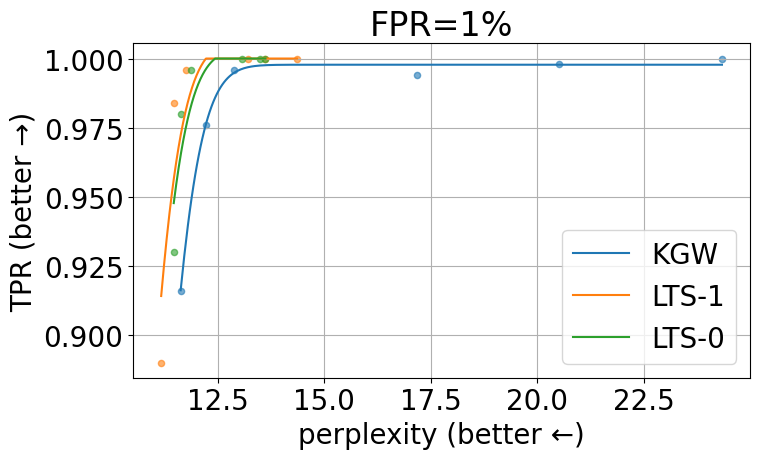

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
    'font.size': 20,              # 默认字体大小
    'axes.titlesize': 24,         # 标题字体大小
    'axes.labelsize': 20,         # 轴标签字体大小
    'xtick.labelsize': 20,        # x轴刻度标签字体大小
    'ytick.labelsize': 20,        # y轴刻度标签字体大小
    'legend.fontsize': 20         # 图例字体大小
})

def five_param_logistic(x, a, b, c, d, g):
    return d + (a - d) / ((1 + (x / c)**b)**g)


def fit_and_plot(method_data):
    plt.figure(figsize=(8, 5))

    for method, points in method_data.items():
        acc_list, ppl_list = zip(*points)
        x = np.array(ppl_list)
        y = np.array(acc_list)

        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = y[sort_idx]

        x_fit = np.linspace(min(x_sorted), max(x_sorted), 300)

        # 五参数Logistic拟合
        try:
            popt_5pl, _ = curve_fit(five_param_logistic, x_sorted, y_sorted,
                                    bounds=([0, 0, 0, 0, 0], [1.5, 10, 100, 1.5, 10]),
                                    maxfev=10000)
            y_fit_5pl = five_param_logistic(x_fit, *popt_5pl)
            y_fit_5pl = np.clip(y_fit_5pl, 0, 1)  # 限制y值不超过1
            if method=="kgw":
                method="KGW"
            elif method=='our1':
                method="LTW-1"
            elif method=="our0":
                method="LTW-0"
            plt.plot(x_fit, y_fit_5pl, label=f"{method}", linestyle='-')
        except Exception as e:
            print(f"[5PL 拟合失败] {method}: {e}")


        plt.scatter(x_sorted, y_sorted, alpha=0.6,s=20)

    plt.xlabel("perplexity (better ←)")
    plt.ylabel("TPR (better →)")
    plt.title("FPR=1%")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('/data3/wcr/my_project/selective_watermark_based_on_semantic/eval/tpr_plot.pdf', bbox_inches='tight')  
    plt.show()


fit_and_plot(method_data)

In [4]:
def compute_tpr_at_fpr( my_wm_z,un_wm_z, fpr, reverse=False):

    sorted_un_wm_z = np.sort(un_wm_z) if reverse else np.sort(un_wm_z)[::-1]  
    threshold = sorted_un_wm_z[int(fpr * len(sorted_un_wm_z))]
    if reverse:
        tp = np.sum(np.array(my_wm_z) < threshold)  
    else:
        tp = np.sum(np.array(my_wm_z) > threshold)
    tpr = tp / len(my_wm_z)  # TPR = TP / (TP + FN)

    
    return tpr

def load_json(file_path):
    """从JSON文件加载数据"""
    with open(file_path, 'r') as f:
        return json.load(f)

In [5]:
tpr_data = load_json("/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/kgw_tpr.json")
kgw_um_score=tpr_data["un_kgw_z"]
tpr_data = load_json("/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/our_tpr_embed_kgw1.json")
our_um_score=tpr_data["un_wm_z"]
tpr_data = load_json("/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/our_tpr_embed_kgw0.json")
our0_um_score=tpr_data["un_wm_z"]

In [6]:
import numpy as np


with open('/data3/wcr/my_project/selective_watermark_based_on_semantic/eval_records/eval_plot/dipper_attack_zscore.json', 'r') as f:
    data_dict = json.load(f)


our0_acc = []
our1_acc = []
kgw_acc = []

fpr = 0.1

for key in sorted(data_dict.keys(), key=lambda x: float(x[1:])):
    our0_score = data_dict[key]['our_wm_output']
    our1_score = data_dict[key]['our_wm_output1']
    kgw_score = data_dict[key]['kgw_wm_output']
    # 计算 TPR
    our0_tpr = compute_tpr_at_fpr(our0_score, our0_um_score, fpr)
    our1_tpr = compute_tpr_at_fpr(our1_score, our_um_score, fpr)
    kgw_tpr = compute_tpr_at_fpr(kgw_score, kgw_um_score, fpr)
    
    # 存储结果
    our0_acc.append(our0_tpr)
    our1_acc.append(our1_tpr)
    kgw_acc.append(kgw_tpr)

print("our0_acc:", our0_acc)
print("our1_acc:", our1_acc)
print("kgw_acc:", kgw_acc)

our0_acc: [np.float64(0.502), np.float64(0.654), np.float64(0.738), np.float64(0.908), np.float64(0.944), np.float64(0.968)]
our1_acc: [np.float64(0.512), np.float64(0.586), np.float64(0.682), np.float64(0.824), np.float64(0.882), np.float64(0.88)]
kgw_acc: [np.float64(0.554), np.float64(0.616), np.float64(0.698), np.float64(0.898), np.float64(0.924), np.float64(0.932)]


In [7]:
methods = ["kgw", "our1", "our0"]
method_data1 = {method: [] for method in methods}
count=0
for ppl_path in  perplexity_json_paths:
    with open(ppl_path, 'r') as f_ppl:
        ppl_json = json.load(f_ppl)

    for method in methods:
        ppl_key = ppl_keys[method]
        if method=="kgw":
            acc = kgw_acc[count]
        elif method=='our0':
            acc = our0_acc[count]
        else:
            acc = our1_acc[count]
        ppl = ppl_json[ppl_key]
        method_data1[method].append((acc, ppl))

    count+=1

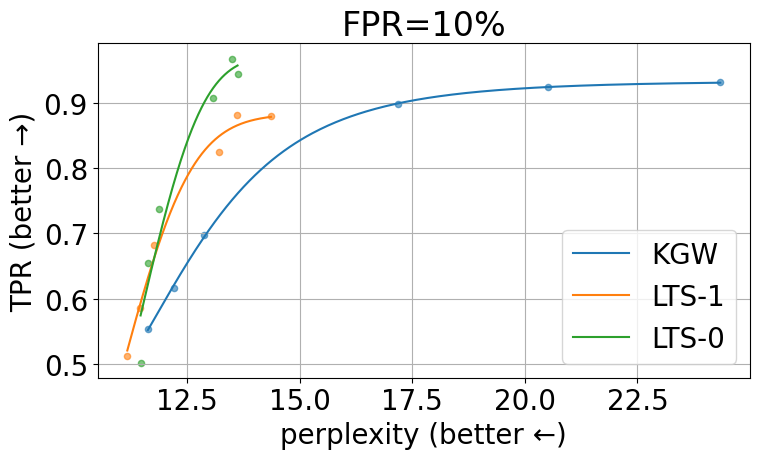

In [ ]:
def fit_and_plot1(method_data):
    plt.figure(figsize=(8, 5))

    for method, points in method_data.items():
        acc_list, ppl_list = zip(*points)
        x = np.array(ppl_list)
        y = np.array(acc_list)

        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = y[sort_idx]

        x_fit = np.linspace(min(x_sorted), max(x_sorted), 300)

        # 五参数Logistic拟合
        try:
            popt_5pl, _ = curve_fit(five_param_logistic, x_sorted, y_sorted,
                                    bounds=([0, 0, 0, 0, 0], [1.5, 10, 100, 1.5, 10]),
                                    maxfev=10000)
            y_fit_5pl = five_param_logistic(x_fit, *popt_5pl)
            y_fit_5pl = np.clip(y_fit_5pl, 0, 1)  # 限制y值不超过1
            if method=="kgw":
                method="KGW"
            elif method=='our1':
                method="LTW-1"
            elif method=="our0":
                method="LTW-0"
            plt.plot(x_fit, y_fit_5pl, label=f"{method}", linestyle='-')
        except Exception as e:
            print(f"[5PL 拟合失败] {method}: {e}")


        plt.scatter(x_sorted, y_sorted, alpha=0.6,s=20)

    plt.xlabel("perplexity (better ←)")
    plt.ylabel("TPR (better →)")
    plt.title("FPR=10%")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('/data3/wcr/my_project/selective_watermark_based_on_semantic/eval/dipper_plot.pdf', bbox_inches='tight')  
    plt.show()


fit_and_plot1(method_data1)